<h1 align="center">
    Exploring visualization module
</h1>


---

In [1]:
import pymove as pm
from pymove.visualization import folium as f, matplotlib as mpl
from pymove.utils import visual
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from folium import Map, plugins
from pymove import PandasMoveDataFrame
from pymove.utils.constants import (
    COUNT,
    DATE,
    DATETIME,
    DAY,
    EVENT_POINT,
    HOUR,
    LATITUDE,
    LONGITUDE,
    PERIOD,
    POI_POINT,
    SITUATION,
    STOP,
    TILES,
    TRAJ_ID,
    USER_POINT,
)
from pymove.utils.datetime import str_to_datetime
from pymove.utils.log import progress_bar
from pymove.utils.visual import add_map_legend, cmap_hex_color
from filter_map import plot_trajectory_by_all_filters, plot_trajectory_by_period
from datetime import datetime
from datetime import date

In [2]:
move_df = pm.read_csv('https://raw.githubusercontent.com/InsightLab/PyMove/master/notebooks/geolife_sample.csv')
chunk1 = move_df[move_df['id'] == 1].head(5000)
chunk5 = move_df[move_df['id'] == 5].head(5000)
move_df = chunk1.append(chunk5)

In [3]:
move_df.generate_day_of_the_week_features()

move_df.generate_time_of_day_features()

move_df.generate_date_features()

move_df.generate_hour_features()

### Exploring data over time

We can generate an overview that contains the distribution of data by time period, time, date, and day of the week to better understand how data is distributed.

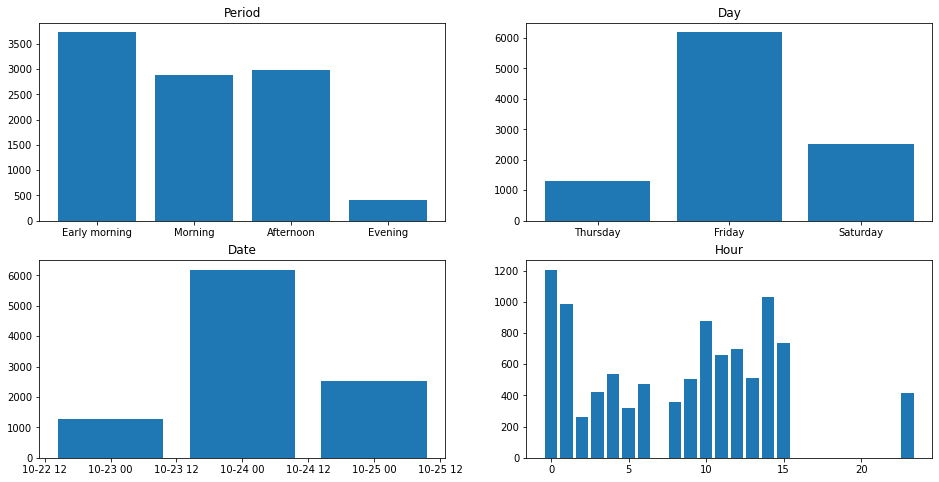

In [4]:
def count_points(column, data):
    list_df = list(move_df[column])
    return list_df.count(data)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

# 01 - Graphic Periods
x_periods = list(move_df.period.unique())
y_periods = []
for data in x_periods:
    y_periods.append(count_points('period', data))

plt.subplot(2, 2, 1)
plt.bar(x_periods, y_periods)
plt.title('Period')

# 02 - Graphic Days
x_days = list(move_df.day.unique())
y_days = []
for data in x_days:
    y_days.append(count_points('day', data))

plt.subplot(2, 2, 2)
plt.bar(x_days, y_days)
plt.title('Day')

# 03 - Graphic Dates
x_dates = list(move_df.date.unique())
y_dates = []
for data in x_dates:
    y_dates.append(count_points('date', data))

plt.subplot(2, 2, 3)
plt.bar(x_dates, y_dates)
plt.title('Date')

# 04 - Graphic Hours
x_hours = list(move_df.hour.unique())
y_hours = []
for data in x_hours:
    y_hours.append(count_points('hour', data))

plt.subplot(2, 2, 4)
plt.bar(x_hours, y_hours)
plt.title('Hour')

plt.show()

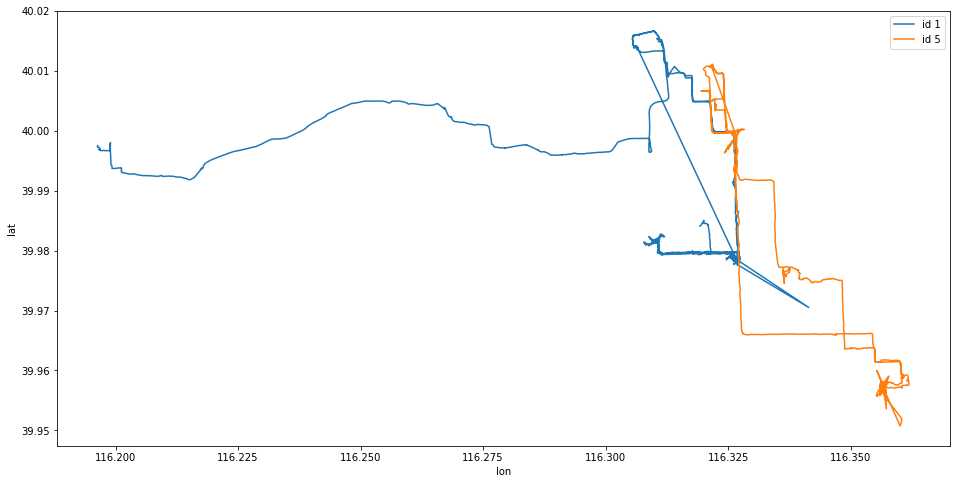

In [5]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

for id in move_df['id'].unique():
    df_ = move_df[move_df['id'] == id]
    plt.plot(df_['lon'], df_['lat'], label='id ' + str(id))

plt.xlabel('lon')
plt.ylabel('lat')
plt.legend()

plt.show()

### Statistics Data

In [6]:
print('Number of points: ' + str(len(move_df)) + '\n')

print('Number of IDs: ' + str(len(move_df['id'].unique())) + '\n')

print('Start Datetime: ' + str(sorted(move_df['datetime'])[0]) +
    ' - End Datetime: ' + str(sorted(move_df['datetime'])[len(move_df)-1]) + '\n')

print('Bounding Box: (lat, lon)\n' +
    ' - Min: (' + str(round(sorted(move_df['lat'])[0], 6)) + ', ' + str(round(sorted(move_df['lon'])[0], 6)) + ')' + '\n'
    ' - Max: (' + str(round(sorted(move_df['lat'])[len(move_df)-1], 6)) + ', ' + str(round(sorted(move_df['lon'])[len(move_df)-1], 6)) + ')')

Number of points: 10000

Number of IDs: 2

Start Datetime: 2008-10-23 05:53:05 - End Datetime: 2008-10-25 14:39:24

Bounding Box: (lat, lon)
 - Min: (39.950729, 116.196292)
 - Max: (40.016703, 116.361914)


In [7]:
days = ['All', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

periods = ['All']
for period in move_df.period.unique():
    periods.append(period)

hours = ['All']
for hour in range(0, 24):
    hours.append(hour)

ids = ['All']
for id in range(1, 11):
    ids.append(id)

### Exploring data

In [25]:
class Widget:
    def __init__(self, widget, name):
        self.widget = widget
        self.name = name

    def getWidget(self):
        return self.widget
    
    def getName(self):
        return self.name

items = [
    Widget(widgets.Dropdown(description='Day:', options=days), 'day'),
    Widget(widgets.Dropdown(description='Period:', options=periods), 'period'),
    Widget(widgets.DatePicker(description='Date:', disabled=False), 'date'),
    Widget(widgets.SelectionSlider(options=hours, value='All', description='Hour:', disabled=False, continuous_update=False, orientation='horizontal', readout=True), 'hour'),
    Widget(widgets.SelectionSlider(options=ids, value='All', description='Id:', disabled=False, continuous_update=False, orientation='horizontal', readout=True), 'id'),
    Widget(widgets.IntText(value=10, description='Number of lines:',disabled=False), 'amount datas'),
    Widget(widgets.Dropdown(description='Page:', options=range(1, 1001)), 'page')
]

amount_datas = items[len(items)-2].getWidget()
pages = items[len(items)-1].getWidget()

items_widgets = []

for widget_obj in items:
    items_widgets.append(widget_obj.getWidget())

widgets_filter = widgets.VBox(children=items_widgets)

button_dataframe = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='success',
    tooltip='Click to submit'
)

button_clean_dataframe = widgets.Button(
    description='Clean',
    disabled=False,
    button_style='danger',
    tooltip='Click to clean'
)

output_dataframe = widgets.Output()

def filter_dataframe():
    move_df_filter = move_df.copy()

    for widget_obj in items:
        widget = widget_obj.getWidget()
        if widget.value != 'All' and widget.value != None and widget != amount_datas and widget != pages:
            if widget.value in list(move_df_filter[widget_obj.getName()]):
                move_df_filter = move_df_filter.loc[move_df_filter[widget_obj.getName()] == widget.value]
            else:
                print('Warning: No ' + widget_obj.getName() + ' in dataframe')
    
    return move_df_filter

def update_pages(len_df, number_lines):
    number_pages = int(len_df / number_lines)

    remaining_pages = 1 if len_df % number_lines > 0 else 0

    pages.options = range(1, number_pages + 1 + remaining_pages)

def show_dataframe(b):
    with output_dataframe:
        output_dataframe.clear_output()

        df_= filter_dataframe()

        len_df = len(df_)
        number_lines = int(amount_datas.value)

        update_pages(len_df, number_lines)

        index = df_.index[0]

        display(df_.loc[index + number_lines * (int(pages.value) - 1) : index + number_lines * int(pages.value) - 1])

def clean_dataframe(b):
    with output_dataframe:
        output_dataframe.clear_output()

button_dataframe.on_click(show_dataframe)
button_clean_dataframe.on_click(clean_dataframe)

labels = widgets.VBox(children=[button_dataframe, button_clean_dataframe])

widgets_with_labels = widgets.VBox(children=[widgets_filter, labels, output_dataframe])

In [26]:
items_for_map = [
    widgets.Dropdown(value='All', description='Day:', options=days),
    widgets.Dropdown(value='All', description='Period:', options=periods),
    widgets.DatePicker(value=move_df['date'].min(), description='Initial date:', disabled=False),
    widgets.DatePicker(value=move_df['date'].max(), description='Final date:', disabled=False),
    widgets.BoundedIntText(value=0,min=0,max=23,step=1,description='Initial hour:',disabled=False),
    widgets.BoundedIntText(value=23,min=0,max=23,step=1,description='Final hour:',disabled=False),
    widgets.SelectionSlider(options=ids, description='Id:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
]

button_map = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='success',
    tooltip='Click to submit'
)

button_clean_map = widgets.Button(
    description='Clean',
    disabled=False,
    button_style='danger',
    tooltip='Click to clean'
)

widgets_for_map = widgets.VBox(children=items_for_map)

output_map = widgets.Output()

widgets_for_map = widgets.VBox(children=[widgets_for_map, button_map, button_clean_map, output_map])

tab = widgets.Tab(children=[widgets_with_labels, widgets_for_map])
tab._titles = {0: 'Dataframe',1: 'Map'}

def show_map(b):
    with output_map:
        output_map.clear_output()

        display(plot_trajectory_by_all_filters(
            move_data=move_df,
            id_=None if (items_for_map[6].value == 'All') else items_for_map[6].value,
            start_hour=items_for_map[4].value,
            end_hour=items_for_map[5].value,
            start_date=(items_for_map[2].value.strftime("%Y/%m/%d")).replace('/', '-'),
            end_date=(items_for_map[3].value.strftime("%Y/%m/%d")).replace('/', '-'),
            period=None if (items_for_map[1].value == 'All') else items_for_map[1].value,
            day_week=None if (items_for_map[0].value == 'All') else items_for_map[0].value
        ))

def clean_map(b):
    with output_map:
        output_map.clear_output()

button_map.on_click(show_map)
button_clean_map.on_click(clean_map)

tab

---

We can generate a visualization of the trajectory points filtered by:

### Exploring trajectories

- **Plot all trajectories**

In [10]:
f.plot_trajectories(move_df)

- **Heat map**

In [11]:
f.heatmap(move_df)

- **Heat map with time**

In [12]:
f.heatmap_with_time(move_df)

- **Faster MarkerCluster**

In [13]:
f.faster_cluster(move_df)

- **Plot stops points**

In [14]:
move_df.generate_tid_based_on_id_datetime()
move_df.generate_move_and_stop_by_radius()

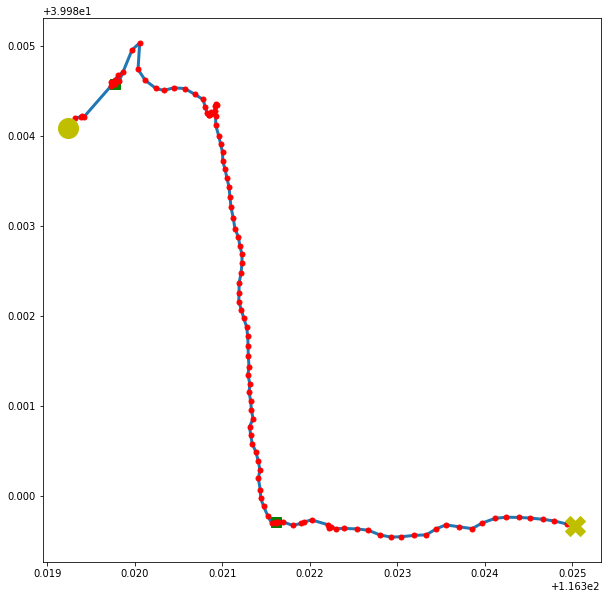

In [15]:
mpl.plot_trajectory_by_id(move_df, id_="12008102305", label='tid', feature="situation", value="stop", return_fig=False)

- **Show lat and lon GPS**

Text(0, 0.5, 'lat')

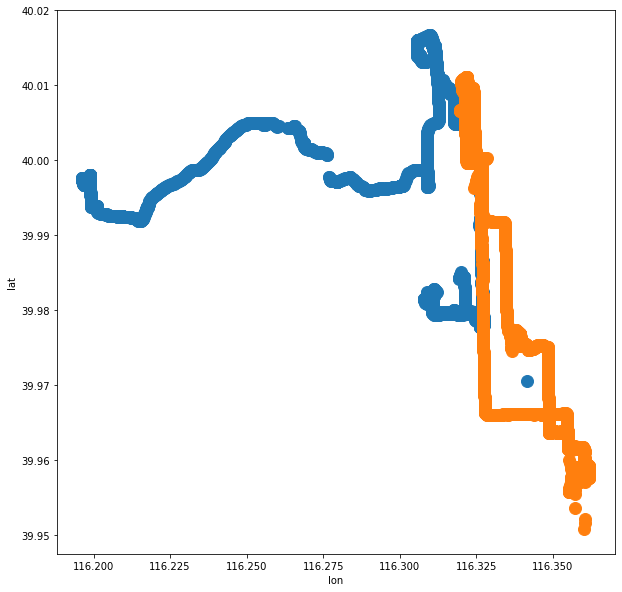

In [16]:
mpl.plot_trajectories(move_df, return_fig=False)

plt.xlabel('lon')
plt.ylabel('lat')